### Emma Klemets, 260775167   
All my work, code, output and written answers are in this notebook.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import integrate
import math

### Problem 1
Write a recursive variable step size integrator like the one we
wrote in class that does NOT call f(x) multiple times for the same x. For a few typical examples, how many function calls do you save vs. the lazy way we wrote it in class?

In [2]:
def simple_integrate(fun,a,b,tol, text=False):
    
    #x to intrate over
    x=np.linspace(a,b,5)
    #dx from x range
    dx=(b-a)/4.0
    #np.median(np.diff(x))
    y=fun(x)
    
    neval=len(x) #let's keep track of function evaluations
    
    #get error of region
    f1=(y[0]+4*y[2]+y[4])/6.0*(b-a)
    f2=(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/12.0*(b-a)
    
    myerr=np.abs(f2-f1)
    
    if text:
        print("interval: ({}, {}), {} {}".format(a,b,f1,f2))
    
    #if within tolerance, return value
    if (myerr<tol):
        #return (f2)/1.0,myerr,neval
        return (16.0*f2-f1)/15.0,myerr,neval
    else: #else split interval and call again
        mid=0.5*(b+a) #split usign new midpoint
        
        f_left,err_left,neval_left=simple_integrate(fun,a,mid,tol/2.0, text=text)
        
        f_right,err_right,neval_right=simple_integrate(fun,mid,b,tol/2.0, text=text)
        
        #put results from split together
        neval=neval+neval_left+neval_right
        f=f_left+f_right
        err=err_left+err_right
        
        return f,err,neval

In [3]:
def simple_integrate_smart(fun,a,b,tol, edges=['n', 'n'], text=False):
    
    #x to intrate over
    x=np.linspace(a,b,5)
    #dx from x range
    dx=(b-a)/4.0

    #For start there are no edge values calculated
    if isinstance(edges[0], str):
        y=fun(x)
        #keep track of function evaluations
        neval=len(x)

    else:
        y=np.concatenate(([edges[0]], fun(x[1:-1]), [edges[1]]))
        #keep track of function evaluations
        neval=len(x[1:-1])
#         print(x[0], x[-1], a, b   
    
    #get error of region
    f1=(y[0]+4*y[2]+y[4])/6.0*(b-a)
    f2=(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/12.0*(b-a)
    
    myerr=np.abs(f2-f1)
    
    if text:
        print("interval: ({}, {}), {} {}".format(a,b,f1,f2))
    
    #if within tolerance, return value
    if (myerr<tol):
        #return (f2)/1.0,myerr,neval
        return (16.0*f2-f1)/15.0,myerr,neval
    else: #else split interval and call again
        mid=0.5*(b+a) #split usign new midpoint
        
        f_left,err_left,neval_left=simple_integrate_smart(fun,a,mid,tol/2.0, [y[0], y[2]], text=text)
        
        f_right,err_right,neval_right=simple_integrate_smart(fun,mid,b,tol/2.0, [y[2], y[-1]], text=text)
        
        #put results from split together
        neval=neval+neval_left+neval_right
        f=f_left+f_right
        err=err_left+err_right
        
        return f,err,neval

In [4]:
#functions to fit
sig=0.1

def fun(x):
    return 1.0/(1.0+x**2)

def fun2(x):
    return 1.0+np.exp(-0.5*x**2/(sig**2))

In [5]:
#TO DO: loop through a couple functions

#function from class
f,err,neval=simple_integrate(np.exp,-1,1,1e-3)
#my smarter function
my_f,my_err,my_neval=simple_integrate_smart(np.exp,-1,1,1e-3)#, text=True)

#exact value
pred=np.exp(1)-np.exp(-1)

#print results
print("value: {:.4e} +/- {:.4e}, function calls: {}".format(f,err,neval))
print("Smart function: \nmy_value: {:.4e} +/- {:.4e}, function calls: {}".format(my_f,my_err,my_neval))

print("Saves {} functions calls. True error: {:.4e}".format(neval-my_neval, np.abs(pred-my_f)))

value: 2.3504e+00 +/- 2.3419e-04, function calls: 25
Smart function: 
my_value: 2.3504e+00 +/- 2.3419e-04, function calls: 17
Saves 8 functions calls. True error: 3.2994e-07


### Problem 2: 
a) Write a function that models the log base 2 of x valid from 0.5 to 1 to an accuracy in the region better than 10−6. Please use a truncated Chebyshev polynomial fit to do this, and please write your own fit routine.   

- How many terms do you need?
    - Carry out a polynomial fit of the same order (we’ll see how to do this ourselves in coming lectures, but for now I suggest just calling np.polynomial.legendre.legfit, which will be more stable than np.polyfit).   
- Plot the residuals for both the truncated Chebyshev and standard polynomial fits. 
    - Which one has higher RMS error? Which one has a larger max error?

In [78]:
log = lambda x: [math.log2(i) for i in x]


Chebyshev Polynomials   
$T_n = cos(n~a~cos(x)) ~~ -1 \leq x \leq 1$   
$T_0=1, T_1=x$  
$T_{n+1}=2\cdot T_N - T_{n-1}$

In [127]:
def cheb_fit(fun,ord):
    x=np.linspace(0.5,1,ord+1)
    y=fun(x)
    
    mat=np.zeros([ord+1,ord+1])
    #set t0 and t1 values
    mat[:,0]=1
    mat[:,1]=x
    
    #fill other Chebyshev Polynomials using recurrence relation
    for i in range(1,ord):
        mat[:,i+1]=2*x*mat[:,i]-mat[:,i-1]
        
    #invert matric and mutliply by y to get coeffs
    coeffs=np.linalg.inv(mat)@y
    return coeffs

def cheb_vals(c, ord):
    x=np.linspace(0.5,1,ord+1)
    
    mat=np.zeros([ord+1,ord+1])
    #set t0 and t1 values
    mat[:,0]=1
    mat[:,1]=x
    
    #fill other Chebyshev Polynomials using recurrence relation
    for i in range(1,ord):
        mat[:,i+1]=2*x*mat[:,i]-mat[:,i-1]
        
    #mulitply by coeff to get y values
    return mat@c

In [128]:
#cheb fit
deg = 7

coeffs=cheb_fit(log,deg)
cheb_fit = cheb_vals(coeffs, deg)

x=np.linspace(0.5,1,deg+1)
y=log(x)

In [129]:
# need better than 10−6
"""
deg - max error
8 = 7.763446774333715e-09
7 - 4.765752237290144e-10
6 - 1.1664269550237805e-10
"""

cheb_rms = np.std(np.abs(cheb_fit-y))
cheb_maxErr = np.max(np.abs(cheb_fit-y))
print(cheb_rms, cheb_maxErr)

1.3760196880220174e-10 4.765752237290144e-10


In [130]:
#polyfit 
xp = np.linspace(0.5, 1, 1000)
# print(x)
yp = [math.log2(i) for i in xp]

# Return the coefficients of a Legendre series, [residuals, rank, singular_values, rcond]
polyfit, polyfit_info = np.polynomial.legendre.legfit(xp, yp, deg, full=True)

polyfit_leg = np.polynomial.legendre.legval(xp, polyfit)

print(len(polyfit_leg))
print(len(xp))

1000
1000


In [131]:

# RMS, max error - should we have abs here?
poly_rms = np.std(np.abs(polyfit_leg-y))
poly_maxErr = np.max(np.abs(polyfit_leg-y))
print(poly_rms, poly_maxErr)

ValueError: operands could not be broadcast together with shapes (1000,) (8,) 

C:\Users\Emma\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


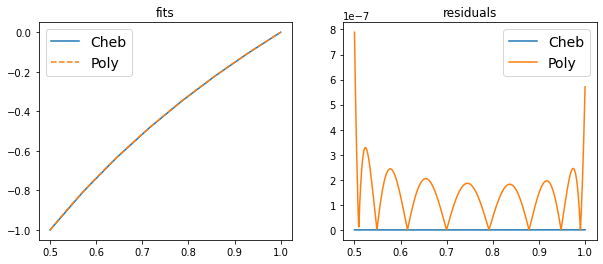

In [134]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(x, cheb_fit, label='Cheb')
ax[0].plot(xp, polyfit_leg, label='Poly', ls="--")
ax[0].set_title("fits")
ax[0].legend(prop={'size': 14})


ax[1].plot(x, np.abs(cheb_fit-y), label='Cheb')
ax[1].plot(xp, np.abs(polyfit_leg-yp), label='Poly')

ax[1].set_title("residuals")
ax[1].legend(prop={'size': 14})
# ax[1].set_ylabel("f' exact - f' approx")

fig.show()

### Problem 3: 

a) Write a program to solve for the decay products of U238
(refer to slides for the decay chain). You can use the ODE solver from scipy, but you’ll need to set the problem up properly. Please make sure to include all the decay prodcuts in the chain. Assume you start from a sample of pure U238 (in nature, this sort of separation happens chemically when rocks are formed). Which solver would you use for this problem? 

b) Plot the ratio of Pb206 to U238 as a function of time over a region where
it’s interesting. Does this make sense analytically? (If you look at the decay chain, all the half-lives are short compared to U238, so you can approximate the U238 decaying instantly to lead. Now plot the ratio of Thorium 230 to U234 over a region where that is interesting. Radioactive decay is frequently used to date rocks, and these results point at how you can determine the age of a uranium-bearing rock that is anywhere from thousands to billions of years old. (Of course, in this case the starting ratio of U234 to U238 would probably have already reached its long-term average when the rock was formed, but you could still use the U234/Th230 ratio under that assumption.)